In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 1


In [4]:
augmented_icm_dir = '/content/drive/MyDrive/pfa-augmented-dataset1/GT_ICM'
augmented_zp_dir = '/content/drive/MyDrive/pfa-augmented-dataset1/GT_ZP'
augmented_te_dir = '/content/drive/MyDrive/pfa-augmented-dataset1/GT_TE'
augmented_images_dir = '/content/drive/MyDrive/pfa-augmented-dataset1/Images'

# read the images and masks
images = []
zp_masks = []
te_masks = []
icm_masks = []
SIZE = 128

file_names = os.listdir(augmented_images_dir)

for file_name in file_names:
    image_path = os.path.join(augmented_images_dir, file_name)
    zp_mask_path = os.path.join(augmented_zp_dir, file_name.replace('.png', ' ZP_Mask.png'))
    te_mask_path = os.path.join(augmented_te_dir, file_name.replace('.png', ' TE_Mask.png'))
    icm_mask_path = os.path.join(augmented_icm_dir, file_name.replace('.png', ' ICM_Mask.png'))

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    zp_mask = cv2.imread(zp_mask_path, cv2.IMREAD_GRAYSCALE)
    te_mask = cv2.imread(te_mask_path, cv2.IMREAD_GRAYSCALE)
    icm_mask = cv2.imread(icm_mask_path, cv2.IMREAD_GRAYSCALE)

    image = cv2.resize(image, (SIZE, SIZE))
    zp_mask = cv2.resize(zp_mask, (SIZE, SIZE))
    te_mask = cv2.resize(te_mask, (SIZE, SIZE))
    icm_mask = cv2.resize(icm_mask, (SIZE, SIZE))

    # Add channel dimension and normalize
    image = np.expand_dims(image, axis=-1) / 255.0
    zp_mask = np.expand_dims(zp_mask, axis=-1) / 255.0
    te_mask = np.expand_dims(te_mask, axis=-1) / 255.0
    icm_mask = np.expand_dims(icm_mask, axis=-1) / 255.0

    images.append(image)
    zp_masks.append(zp_mask)
    te_masks.append(te_mask)
    icm_masks.append(icm_mask)

# Convert lists to numpy arrays
images = np.array(images)
zp_masks = np.array(zp_masks)
te_masks = np.array(te_masks)
icm_masks = np.array(icm_masks)

print(images.shape)
print(zp_masks.shape)
print(te_masks.shape)
print(icm_masks.shape)

(747, 128, 128, 1)
(747, 128, 128, 1)
(747, 128, 128, 1)
(747, 128, 128, 1)


In [7]:
def conv_block(input, num_filters):
    conv = keras.layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(input)
    conv = keras.layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
    return conv
def encoder_block(input, num_filters):
    conv = conv_block(input, num_filters)
    pool = keras.layers.MaxPooling2D((2, 2))(conv)
    return conv, pool
def decoder_block(input, skip_features, num_filters):
    uconv = keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    con = keras.layers.concatenate([uconv, skip_features])
    conv = conv_block(con, num_filters)
    return conv

def build_multi_output_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    s1, p1 = encoder_block(input_layer, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Three output layers: ZP, ICM, TE
    zp_output = keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid", name="zp_output")(d4)
    icm_output = keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid", name="icm_output")(d4)
    te_output = keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid", name="te_output")(d4)

    model = keras.models.Model(inputs=input_layer, outputs=[zp_output, icm_output, te_output], name="Multi-Output-U-Net")
    return model

model = build_multi_output_model(input_shape=(SIZE, SIZE, 1))
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=['accuracy','accuracy','accuracy'])

In [8]:
EPOCHS = 50
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

X_train, X_val, zp_train, zp_val, icm_train, icm_val, te_train, te_val = train_test_split(
    images, zp_masks, icm_masks, te_masks, test_size=0.2, random_state=42)

history = model.fit(
    X_train,
    [zp_train, icm_train, te_train],
    epochs=EPOCHS,
    validation_data=(X_val, [zp_val, icm_val, te_val]),
    batch_size=8,
    callbacks=[early_stopping]
)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 71s 547ms/step - icm_output_accuracy: 0.8731 - icm_output_loss: 0.3878 - loss: 1.3509 - te_output_accuracy: 0.8502 - te_output_loss: 0.4362 - zp_output_accuracy: 0.8491 - zp_output_loss: 0.5269 - val_icm_output_accuracy: 0.9172 - val_icm_output_loss: 0.2434 - val_loss: 0.8764 - val_te_output_accuracy: 0.8787 - val_te_output_loss: 0.2720 - val_zp_output_accuracy: 0.8504 - val_zp_output_loss: 0.3607
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 153ms/step - icm_output_accuracy: 0.9163 - icm_output_loss: 0.2360 - loss: 0.8496 - te_output_accuracy: 0.8763 - te_output_loss: 0.2479 - zp_output_accuracy: 0.8497 - zp_output_loss: 0.3657 - val_icm_output_accuracy: 0.9172 - val_icm_output_loss: 0.1987 - val_loss: 0.7532 - val_te_output_accuracy: 0.8844 - val_te_output_loss: 0.2058 - val_zp_output_accuracy: 0.8504 - val_zp_output_loss: 0.3483
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 161ms/step - icm_output_accuracy: 0.9176 - icm_output_loss: 0.2081 - loss: 0.762

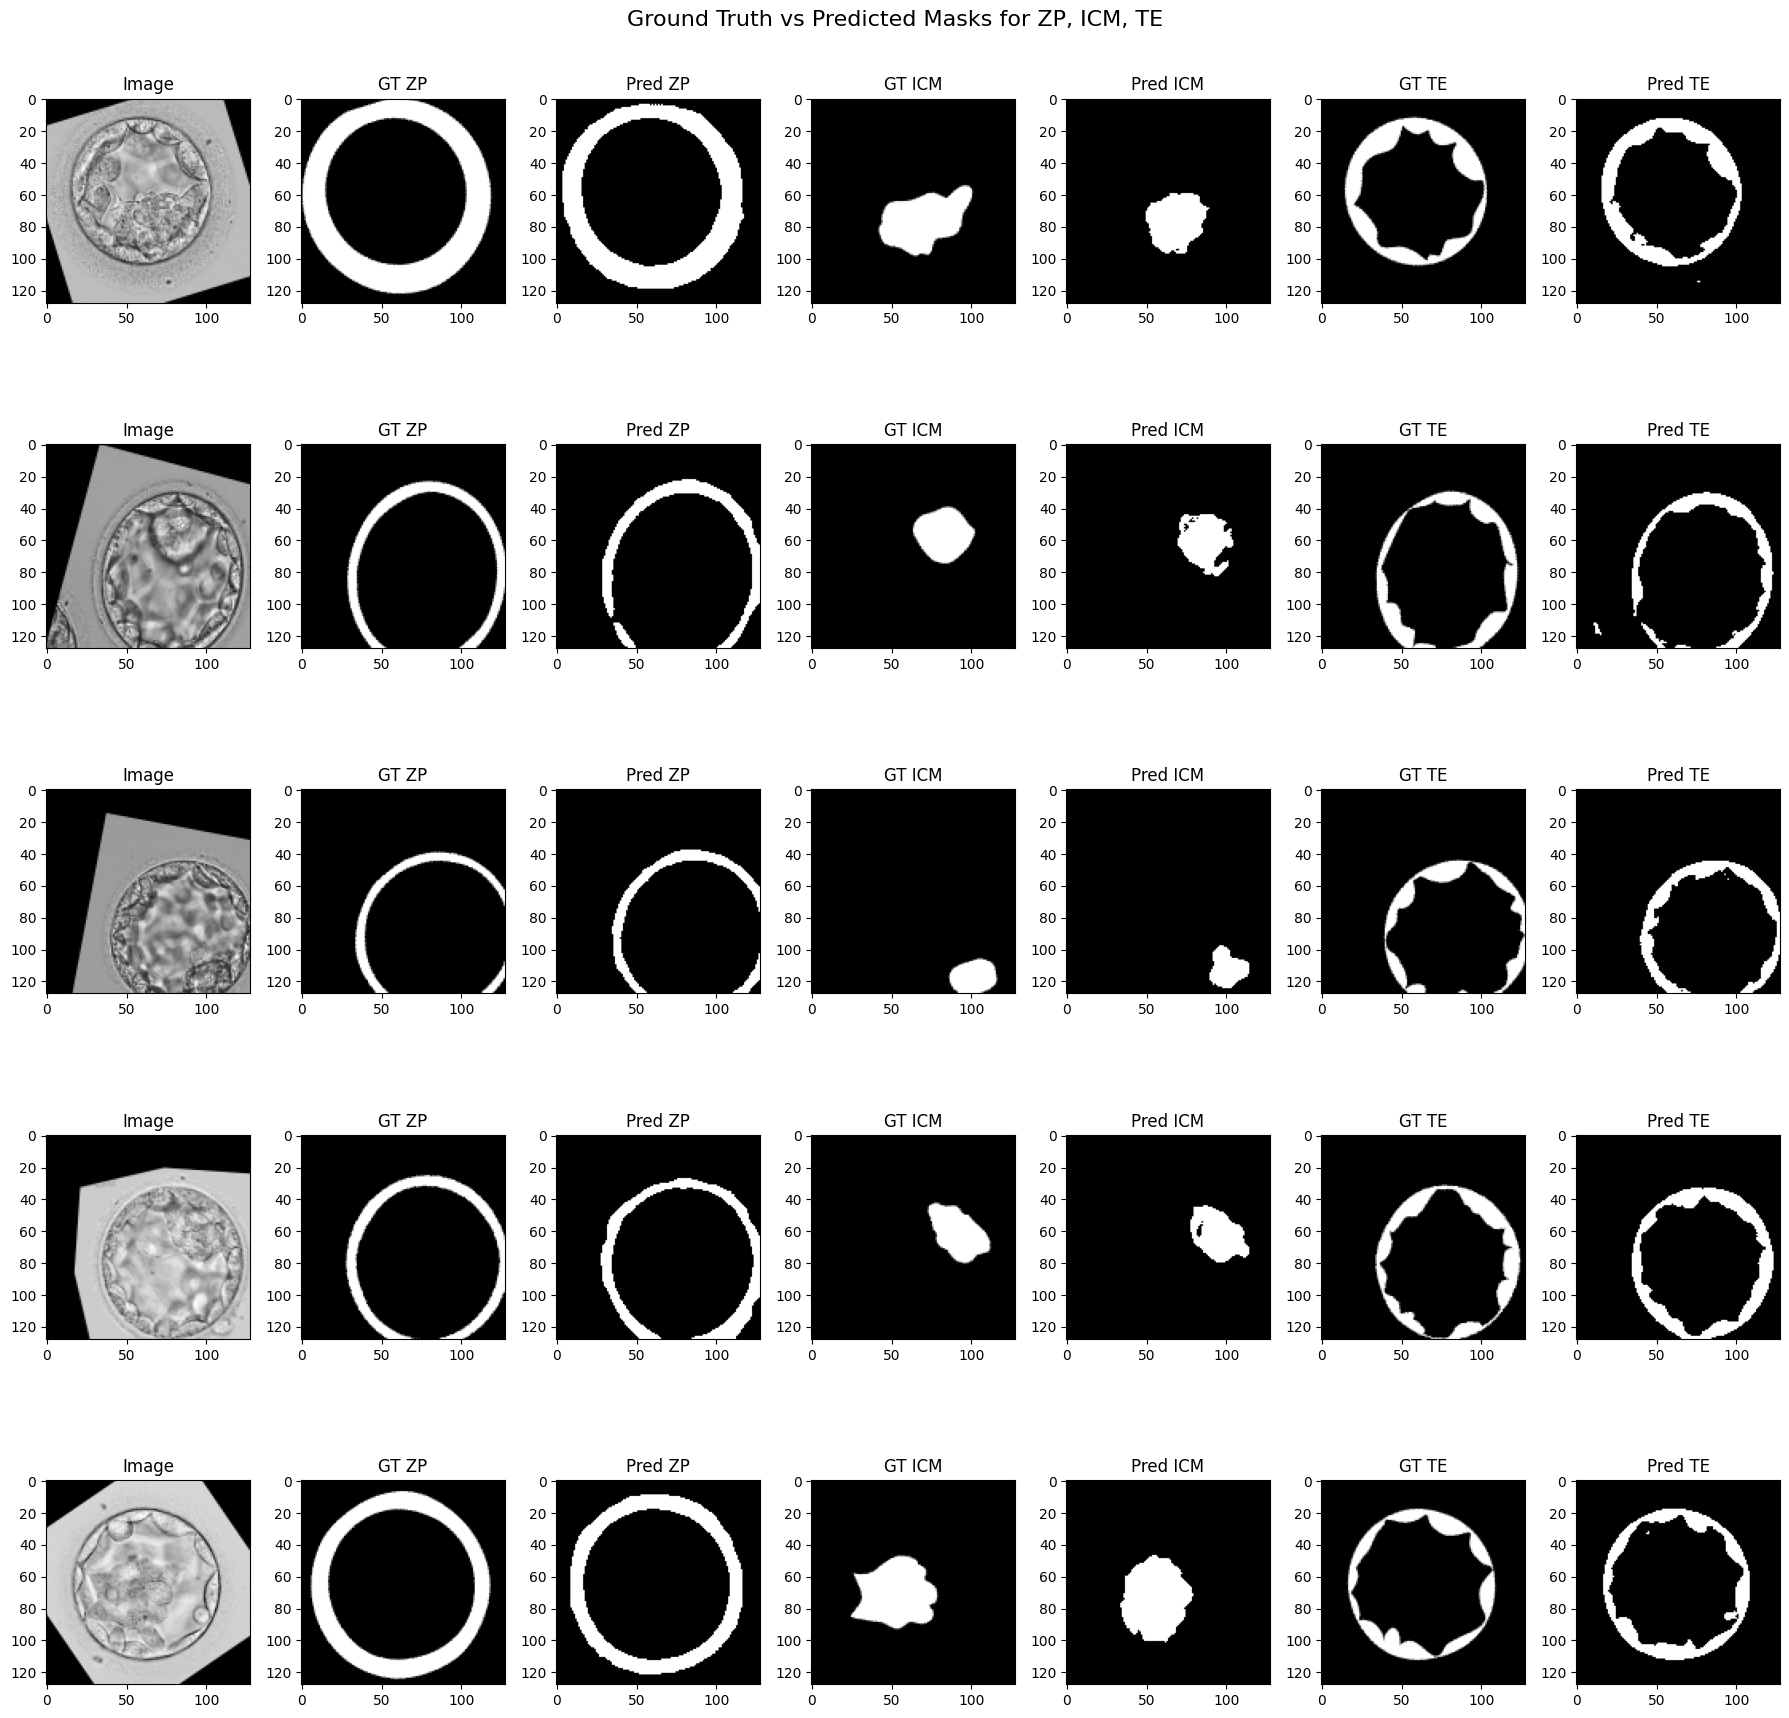

In [10]:
fig, ax = plt.subplots(5, 7, figsize=(18, 18))

# Select 5 random validation samples
j = np.random.randint(0, X_val.shape[0], 5)

for i in range(5):
    # Display the original image
    ax[i, 0].imshow(X_val[j[i]], cmap='gray')
    ax[i, 0].set_title('Image')

    # Display the ground truth ZP mask
    ax[i, 1].imshow(zp_val[j[i]], cmap='gray')
    ax[i, 1].set_title('GT ZP')

    # Display the predicted ZP mask
    pred_zp = model.predict(np.expand_dims(X_val[j[i]], 0), verbose=0)[0]
    pred_zp = (pred_zp > 0.5).astype(np.uint8)
    ax[i, 2].imshow(pred_zp[0], cmap='gray')
    ax[i, 2].set_title('Pred ZP')

    # Display the ground truth ICM mask
    ax[i, 3].imshow(icm_val[j[i]], cmap='gray')
    ax[i, 3].set_title('GT ICM')

    # Display the predicted ICM mask
    pred_icm = model.predict(np.expand_dims(X_val[j[i]], 0), verbose=0)[1]
    pred_icm = (pred_icm > 0.5).astype(np.uint8)
    ax[i, 4].imshow(pred_icm[0], cmap='gray')
    ax[i, 4].set_title('Pred ICM')

    # Display the ground truth TE mask
    ax[i, 5].imshow(te_val[j[i]], cmap='gray')
    ax[i, 5].set_title('GT TE')

    # Display the predicted TE mask
    pred_te = model.predict(np.expand_dims(X_val[j[i]], 0), verbose=0)[2]
    pred_te = (pred_te > 0.5).astype(np.uint8)
    ax[i, 6].imshow(pred_te[0], cmap='gray')
    ax[i, 6].set_title('Pred TE')

fig.suptitle('Ground Truth vs Predicted Masks for ZP, ICM, TE', fontsize=16)
plt.tight_layout()
plt.show()